# The Basis Mixer!

The previous notebooks explored the individual components of the Basis Function Models. In this notebook we will put everything together to render an expressive performance of a piece given its score.

In [1]:
import numpy as np
from partitura import save_performance_midi, load_musicxml
from partitura.score import expand_grace_notes

from basismixer.performance_codec import get_performance_codec
from helper import load_model, compute_basis_from_xml
from helper.rendering import post_process_predictions

## 0. Select a piece and trained models
We start by defining the piece we want to render (here is an example MusicXML file, but you can set your own!)

In [2]:
xml_fn = './sample_data/musicxml/Chopin_op28_No7.musicxml'

Now we set the path to the directory of the trained models from our previous notebook (or any other trained models). Following the directory structure from the previous notebook, each

In [3]:
models_dir = './vienna4x22_norm_rec_models/'

## 1. Load the Predictive Model

The function `load_model` looks for the configuration files and the saved model parameters in `models_dir`. This function will return an instance of `FullPredictiveModel`, which is a conveniece *meta-model* which contains a list of the individual models (in `model.models`).

In [4]:
model = load_model(models_dir)
print(model)

FullPredictiveModel(
  (models): ModuleList(
    (0): RecurrentModel(
      (rnn): GRU(38, 128, batch_first=True, bidirectional=True)
      (dense): Linear(in_features=256, out_features=64, bias=True)
      (output): Linear(in_features=64, out_features=4, bias=True)
    )
    (1): RecurrentModel(
      (rnn): GRU(38, 128, batch_first=True, bidirectional=True)
      (dense): Linear(in_features=256, out_features=64, bias=True)
      (output): Linear(in_features=64, out_features=3, bias=True)
    )
  )
)


## 2. Computing the Score Representation.

We load the input MusicXML file specified above and compute the input score representation using the Basis Functions specified by the model (in `model.input_names`).

In [5]:
# Load MusicXML file
basis, part = compute_basis_from_xml(xml_fn, model.input_names)

[WARNING] Dropping slur 2 starting at 176 (n166) and ending at 176 (n169)


## 3. Make Predict Performance

We make predictions of the performance using the models. , The `predict` method of `FullPredictiveModel` combines the predictions of the individual predictive models into a single output structured array, where the field names are the output parameters (specified in `model.output_names`).

In [6]:
preds = model.predict(basis, part.note_array['onset'])
post_process_predictions(preds)
print('Field names:', preds.dtype.names)

Field names: ('articulation_log', 'beat_period_mean', 'beat_period_standardized', 'beat_period_std', 'timing', 'velocity_dev', 'velocity_trend')


## 4. Decode predictions

Finally, we decode the predictions using a `PerformanceCodec` and export the performance as a MIDI file. The output of the `decode` method is an instance of `partitura.performance.PerformedPart`.

In [7]:
perf_codec = get_performance_codec(model.output_names)
predicted_ppart = perf_codec.decode(part, preds)

In [8]:
# import matplotlib.pyplot as plt
# fig = plt.figure()
# plt.hist(predicted_ppart.note_array['p_duration'], 100); plt.show()

Finally, we can export the predictions of the model as a MIDI file!

In [9]:
midi_fn = 'my_midi_output.mid'
save_performance_midi(predicted_ppart, midi_fn)

In [10]:
from helper.rendering import render_midi_file

render_midi_file(midi_fn)

<DisplayHandle display_id=839886c685a086e3d4a36767c7d3c11a>

<IPython.core.display.Javascript object>


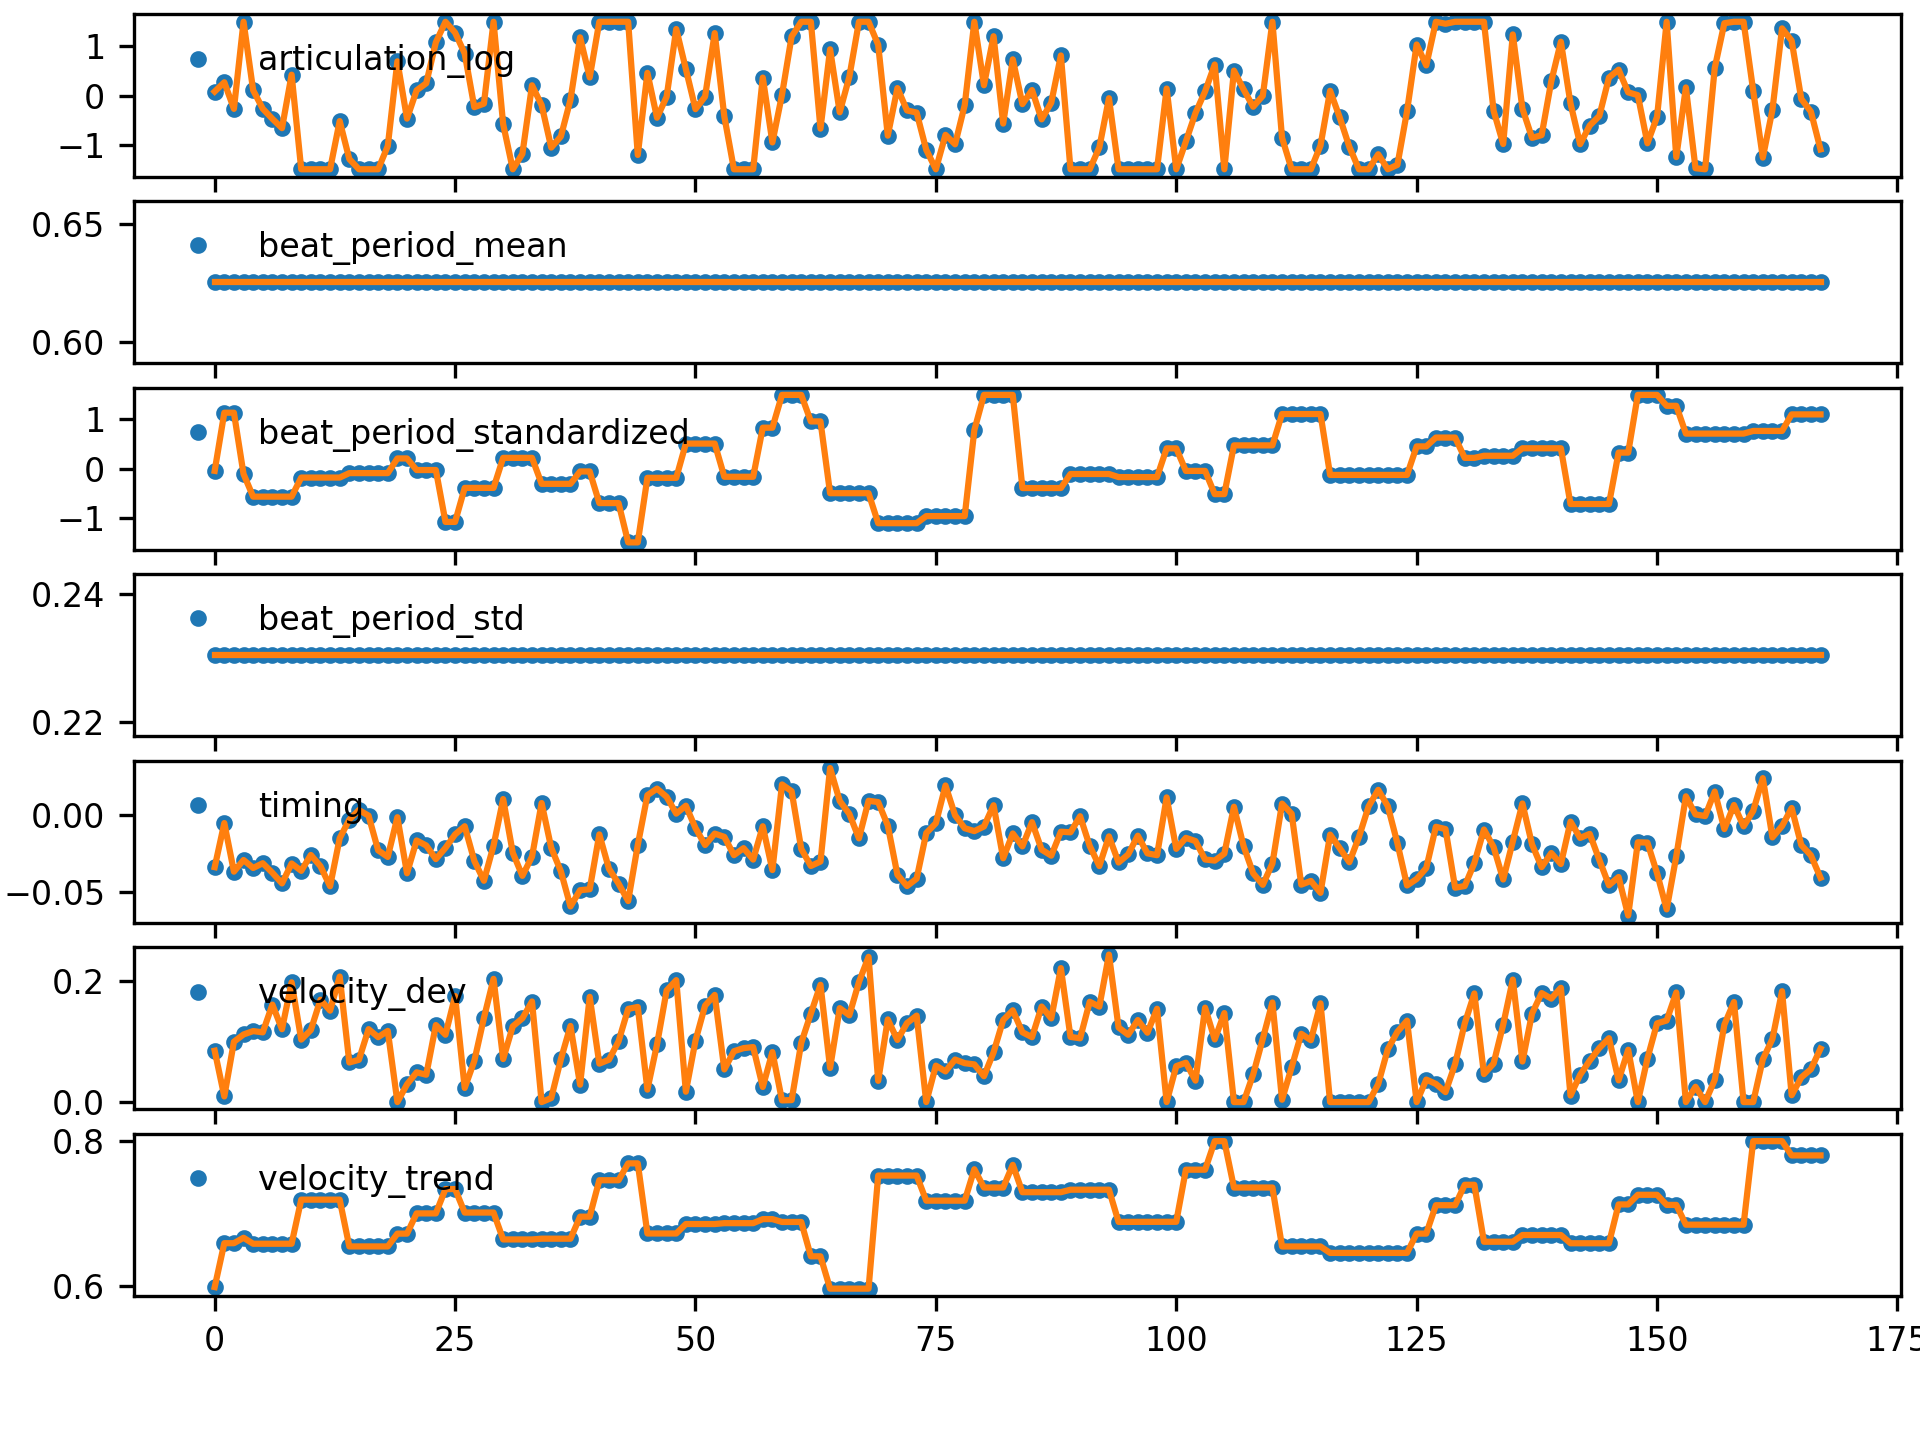

In [11]:
%matplotlib notebook
from helper.plotting import plot_predictions
plot_predictions(preds)